In [4]:
import os
import numpy as np
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
tf.random.set_seed(1)


inputs = keras.Input(shape=(128, 128, 3), name="img")
x = layers.Conv2D(128, 3, activation="relu")(inputs)
x = layers.Conv2D(256, 3, activation="relu")(x)
block_1_output = layers.MaxPooling2D(3)(x)

x = layers.Conv2D(256, 3, activation="relu", padding="same")(block_1_output)
x = layers.Conv2D(256, 3, activation="relu", padding="same")(x)
block_2_output = layers.add([x, block_1_output])

x = layers.Conv2D(256, 3, activation="relu", padding="same")(block_2_output)
x = layers.Conv2D(256, 3, activation="relu", padding="same")(x)
block_3_output = layers.add([x, block_2_output])

x = layers.Conv2D(256, 3, activation="relu")(block_3_output)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(1024, activation="relu")(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(512, activation="relu")(x)
x = layers.Dense(256, activation="relu")(x)
x = layers.Dense(128, activation="relu")(x)
x = layers.Dense(64, activation="relu")(x)
x = layers.Dense(32, activation="relu")(x)
outputs = layers.Dense(2, activation='sigmoid')(x) #softmax если более 2 классов

model = keras.Model(inputs, outputs, name="toy_resnet")

model.compile(optimizer='adam',
             loss='categorical_crossentropy',
             metrics=['accuracy'])


In [5]:
model.summary()

Model: "toy_resnet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 img (InputLayer)               [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 126, 126, 12  3584        ['img[0][0]']                    
                                8)                                                                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 124, 124, 25  295168      ['conv2d[0][0]']                 
                                6)                                                       

In [7]:
import numpy as np
from sklearn.model_selection import train_test_split
x_all= np.load('x_all.npy')
y_all = np.load('y_all.npy')
x_train, x_test, y_train, y_test = train_test_split(x_all, y_all, test_size=0.2)
x_train = x_train / 255
x_test = x_test / 255

y_train = keras.utils.to_categorical(y_train, 2)
y_test = keras.utils.to_categorical(y_test, 2)

In [8]:
from tensorflow.keras.callbacks import EarlyStopping
callback = EarlyStopping(monitor='loss', patience=2, min_delta=0.0010)
model.fit(x_train, y_train, batch_size=32, epochs=14, validation_split=0.2, callbacks=[callback])

Epoch 1/14
64/64 [==============================] - 1813s 28s/step - loss: 0.3243 - accuracy: 0.8259 - val_loss: 0.1865 - val_accuracy: 0.9409
Epoch 2/14
64/64 [==============================] - 1808s 28s/step - loss: 0.1871 - accuracy: 0.9502 - val_loss: 0.0532 - val_accuracy: 0.9902
Epoch 3/14
64/64 [==============================] - 1808s 28s/step - loss: 0.0699 - accuracy: 0.9813 - val_loss: 0.0406 - val_accuracy: 0.9882
Epoch 4/14
64/64 [==============================] - 1798s 28s/step - loss: 0.0944 - accuracy: 0.9739 - val_loss: 0.0745 - val_accuracy: 0.9941
Epoch 5/14
64/64 [==============================] - 1804s 28s/step - loss: 0.0850 - accuracy: 0.9739 - val_loss: 0.0420 - val_accuracy: 0.9941


In [9]:
print(model.evaluate(x_test, y_test))

20/20 [==============================] - 226s 11s/step - loss: 0.0383 - accuracy: 0.9890
[0.03825189918279648, 0.9889763593673706]


In [12]:
# сохранение
with open('my_train_test_split/x_train.npy', 'wb') as f:
    np.save(f, x_train)

with open('my_train_test_split/x_test.npy', 'wb') as f:
    np.save(f, x_test)

with open('my_train_test_split/y_train.npy', 'wb') as f:
    np.save(f, y_train)

with open('my_train_test_split/y_test.npy', 'wb') as f:
    np.save(f, y_test)

model.save('modelv1_noname_v2')

INFO:tensorflow:Assets written to: modelv1_noname_v2\assets


INFO:tensorflow:Assets written to: modelv1_noname_v2\assets


Подбор порога

In [14]:
from sklearn.metrics import accuracy_score
y_pred = model.predict(x_test)

20/20 [==============================] - 227s 11s/step


ValueError: Classification metrics can't handle a mix of multilabel-indicator and continuous-multioutput targets

In [21]:
from tqdm import tqdm

results = {'threshold':[], 'accuracy_score':[]}
iters = y_pred[:, 1].copy()
iters.sort()

for i in tqdm(iters):
    predict_mine = []
    for i2 in y_pred:
        if i2[1]>i:
            predict_mine.append([0.0,1.0])
        else:
            predict_mine.append([1.0, 0.0])
            
    results['threshold'].append(i)
    results['accuracy_score'].append(accuracy_score(y_test, predict_mine))

100%|██████████| 635/635 [00:01<00:00, 492.17it/s]


Text(0, 0.5, 'accuracy_score')

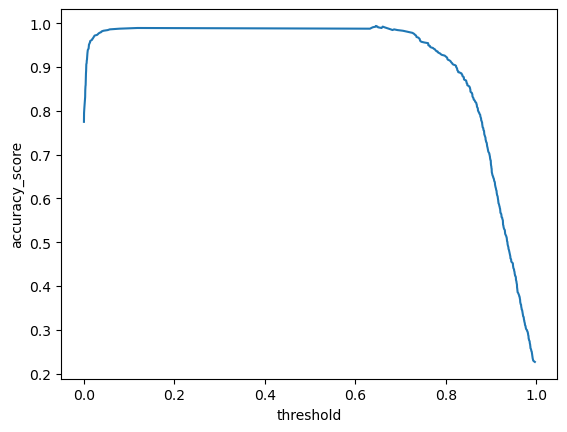

In [26]:
import matplotlib.pyplot as plt
plt.plot(results['threshold'], results['accuracy_score'])
plt.xlabel('threshold')
plt.ylabel('accuracy_score')

In [38]:
best_acc = max(results['accuracy_score'])
best_threshold = results['threshold'][results['accuracy_score'].index(best_acc)]
print(f'Лучший порог:{best_threshold} Лучшая точность:{best_acc}')

Лучший порог:0.6455790400505066 Лучшая точность:0.9937007874015747
